In [544]:
from optuna.integration.lightgbm import lgb
import pandas as pd
import numpy as np
import optuna
import shap
import pickle
import os
from tqdm import tqdm
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [545]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [546]:
df = pd.read_csv('train_merged.csv')
ignore_features_binary = ['end_code', 'allCars', 'start_code', 'KP', 'is_congestion', 'holiday', 'speed_change_hour_move_ave_7d']
categorical_features = ['day_of_week', 'section', 'n_of_holidays']
df['datetime'] = pd.to_datetime(df['datetime'])

# sample_weightに入れる重みを計算
coef_0 = 1
coef_1 = 1

weight_binary = compute_sample_weight(class_weight='balanced', y=df['is_congestion_tomorrow'])
weight_df = pd.DataFrame()
weight_df['is_congestion_tomorrow'] = df['is_congestion_tomorrow']
weight_df['weight_binary'] = weight_binary
weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight_binary'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight_binary'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
df['weight_binary'] = weight_df['weight_binary']

df_train = df[df['datetime'] < start_date+' 00:00:00']
df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]


In [547]:
def find_optimal_threshold(answer, prob_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        prediction = (prob_scores > threshold).astype(int)
        score = f1_score(answer, prediction)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

In [548]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

folds = tss(n_splits=5)

test_x_binary = df_test.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'tomorrow_holiday', 'weight_binary', *ignore_features_binary], axis=1)
test_y_binary = df_test['is_congestion_tomorrow']

[LightGBM] [Info] Number of positive: 2020, number of negative: 303415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 305435, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.651799 -> initscore=0.626955
[LightGBM] [Info] Start training from score 0.626955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	Train's binary_logloss: 0.188852	Test's binary_logloss: 0.356159


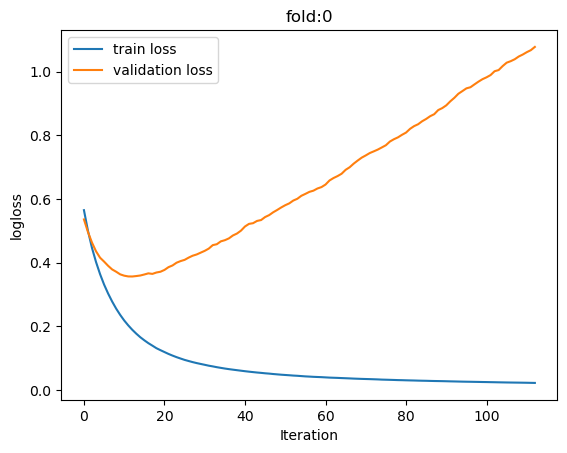

100%|██████████| 30/30 [00:00<00:00, 334.16it/s]


Fold 0:
TN  FP
FN  TP
[[200952   4104]
 [   403    420]]
Accuracy: 0.978108500624153
Recall: 0.5103280680437424
Precision: 0.09283819628647215
F1 score : 0.15709743781559754
---------------------------------------------

[LightGBM] [Info] Number of positive: 5146, number of negative: 605720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 610866, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704904 -> initscore=0.870761
[LightGBM] [Info] Start training from score 0.870761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	Train's binary_logloss: 0.127991	Test's binary_logloss: 0.287144


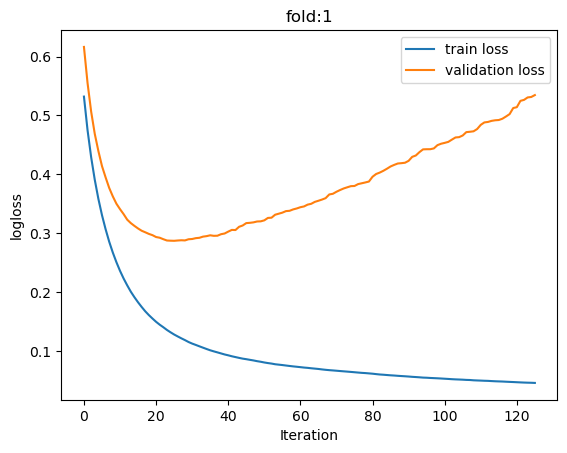

100%|██████████| 30/30 [00:00<00:00, 323.89it/s]


Fold 1:
TN  FP
FN  TP
[[203623   1433]
 [   496    327]]
Accuracy: 0.9906304188382496
Recall: 0.3973268529769137
Precision: 0.18579545454545454
F1 score : 0.25319396051103366
---------------------------------------------

[LightGBM] [Info] Number of positive: 6746, number of negative: 909551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3395
[LightGBM] [Info] Number of data points in the train set: 916297, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.675892 -> initscore=0.734958
[LightGBM] [Info] Start training from score 0.734958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	Train's binary_logloss: 0.1055	Test's binary_logloss: 0.244589


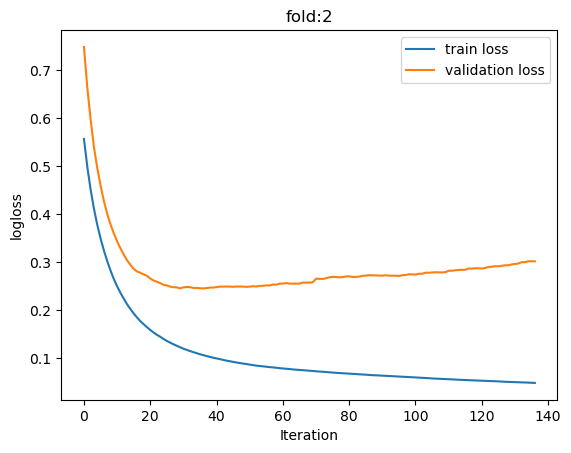

100%|██████████| 30/30 [00:00<00:00, 276.79it/s]


Fold 2:
TN  FP
FN  TP
[[203392   1664]
 [   462    361]]
Accuracy: 0.9896735461120367
Recall: 0.43863912515188336
Precision: 0.1782716049382716
F1 score : 0.2535112359550562
---------------------------------------------

[LightGBM] [Info] Number of positive: 7345, number of negative: 1214383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 1221728, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629713 -> initscore=0.530988
[LightGBM] [Info] Start training from score 0.530988
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	Train's binary_logloss: 0.13893	Test's binary_logloss: 0.289547


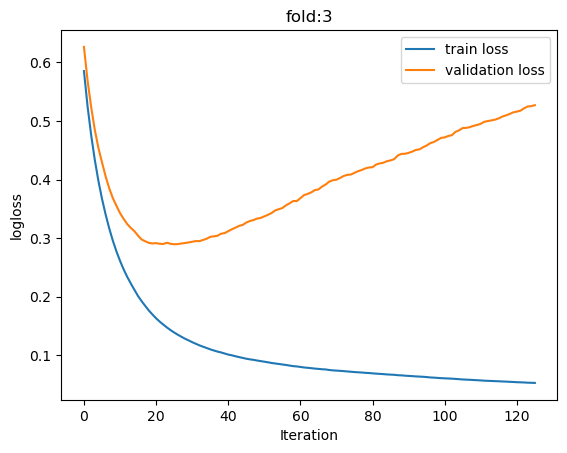

100%|██████████| 30/30 [00:00<00:00, 320.00it/s]


Fold 3:
TN  FP
FN  TP
[[203721   1335]
 [   493    330]]
Accuracy: 0.9911209982562573
Recall: 0.40097205346294046
Precision: 0.1981981981981982
F1 score : 0.26527331189710607
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 8682, number of negative: 1518477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3530
[LightGBM] [Info] Number of data points in the train set: 1527159, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616507 -> initscore=0.474748
[LightGBM] [Info] Start training from sco

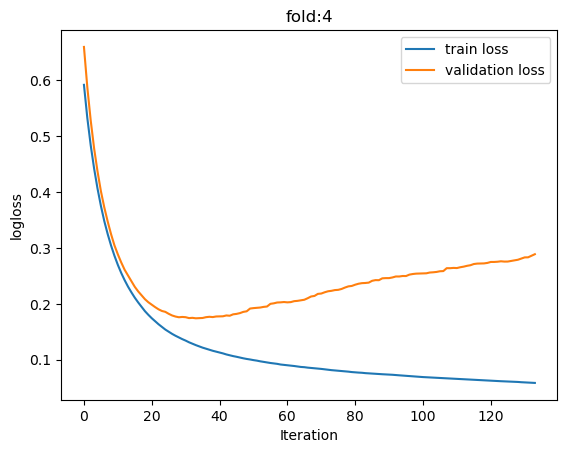

100%|██████████| 30/30 [00:00<00:00, 273.50it/s]


Fold 4:
TN  FP
FN  TP
[[203615   1441]
 [   464    359]]
Accuracy: 0.9907469921653009
Recall: 0.4362089914945322
Precision: 0.19944444444444445
F1 score : 0.2737323675181091
---------------------------------------------



In [549]:
lgb_models_binary = []
best_thresholds = []
predictions = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'binary',    # 回帰を指定
        'metric': 'binary_logloss',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['is_congestion_tomorrow']
    train_x = train.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'datetime', 'weight_binary', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    val_y = val['is_congestion_tomorrow']
    val_x = val.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'datetime', 'weight_binary', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    
    weight_train = train['weight_binary']
    weight_val = val['weight_binary']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_binary.append(model)
    
    loss_train = lgb_results['Train']['binary_logloss']
    loss_test = lgb_results['Test']['binary_logloss']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_binary.groupby(test_x_binary['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'is_congestion_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer = answer_df['is_congestion_tomorrow']
    prediction = answer_df['prediction']
    best_threshold = find_optimal_threshold(answer, prediction)[1]
    best_thresholds.append(best_threshold)
    best_predict = (prediction > best_threshold).astype(int)
    
    predictions.append(best_predict)
    
    accuracy = accuracy_score(answer, best_predict)
    recall = recall_score(answer, best_predict)
    precision = precision_score(answer, best_predict)
    f1 = f1_score(answer, best_predict)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer, best_predict))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

In [550]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [551]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[196778   1420]
 [   423    358]]
Accuracy: 0.9907377160403862
Recall: 0.45838668373879643
Precision: 0.2013498312710911
F1 score : 0.27979679562329035


Only holiday
TN  FP
FN  TP
[[61014   308]
 [  201   227]]
Accuracy: 0.991757085020243
Recall: 0.530373831775701
Precision: 0.42429906542056073
F1 score : 0.4714434060228453


In [552]:
best_thresholds

[0.787878787878788,
 0.9494949494949496,
 0.9494949494949496,
 0.9393939393939394,
 0.9494949494949496]

In [553]:
model_names = {
    0: "model_fold_0",
    1: "model_fold_1",
    2: "model_fold_2",
    3: "model_fold_3",
    4: "model_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_binary):
    model_name = model_names.get(fold, f'model_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

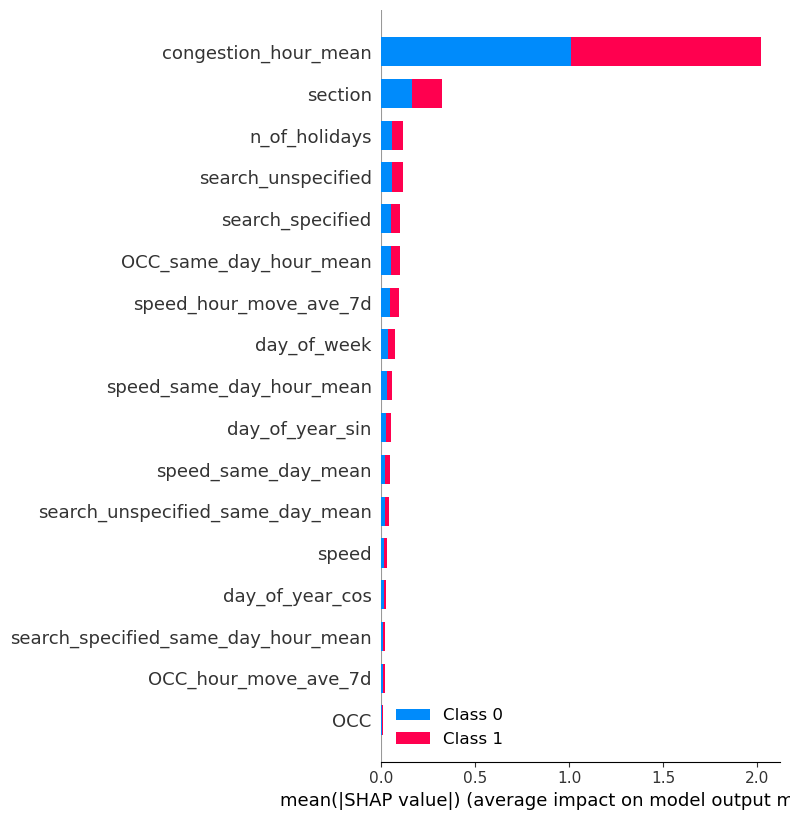

In [554]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(val_x.reset_index(drop=True))

shap.summary_plot(shap_values, val_x.reset_index(drop=True), show=False)
plt.show()

In [555]:
shap.plots.bar(shap_values, max_display=40)
plt.show()

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [ ]:
#shap.decision_plot(explainer.expected_value, explainer.shap_values(val_x), val_x, show=False, ignore_warnings=True)
#plt.show()